In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.17.0


In [ ]:
!unzip Test.zip
!unzip Train.zip

Archive:  Test.zip
replace Test/0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  Train.zip
replace Train/Acadian_Flycatcher_0001_526757101.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_txt_dir = '/content/train.txt'
test_txt_dir= '/content/test.txt'
train_dir = '/content/Train'
test_dir = '/content/Test'


In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        return file.read().splitlines()

train_data = load_data(train_txt_dir)
test_data = load_data(test_txt_dir)

training_feature = pd.DataFrame([line.split() for line in train_data], columns=['filename', 'class_name'])
test_feature = pd.DataFrame([line.split() for line in test_data], columns=['filename', 'class_name'])

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_image_generator = ImageDataGenerator(
    rescale = 1.0/255.0,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = False,
    rotation_range = 30,
)


train_dataset = train_image_generator.flow_from_dataframe(
    training_feature,
    directory = train_dir,
    x_col='filename',
    y_col='class_name',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)


test_image_generator = ImageDataGenerator(rescale=1.0/255.0)

test_dataset = test_image_generator.flow_from_dataframe(
    test_feature,
    directory = test_dir,
    x_col = 'filename',
    y_col = 'class_name',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = 'categorical'
)


Found 4829 validated image filenames belonging to 200 classes.
Found 1204 validated image filenames belonging to 200 classes.


In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=l2(0.001))(x) # Use regulizer to avoid overfitting
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
prediction_layer = Dense(200, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs=prediction_layer)

In [ ]:
base_model.trainable = True
fine_tune_at = 100  # Unfreeze from the 100th layer onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
INITIAL_EPOCHS = 35

history = model.fit(
    train_dataset,
    steps_per_epoch = train_dataset.samples // BATCH_SIZE,
    epochs = INITIAL_EPOCHS,
    validation_data = test_dataset,
    validation_steps = test_dataset.samples // BATCH_SIZE,
)


Epoch 1/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 0.3319 - loss: 4.0681 - val_accuracy: 0.2804 - val_loss: 4.1381
Epoch 2/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4062 - loss: 3.6294 - val_accuracy: 0.4000 - val_loss: 3.9903
Epoch 3/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.4151 - loss: 3.4944 - val_accuracy: 0.3539 - val_loss: 3.8206
Epoch 4/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.4375 - loss: 3.0809 - val_accuracy: 0.5000 - val_loss: 3.6762
Epoch 5/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.5078 - loss: 3.0442 - val_accuracy: 0.4206 - val_loss: 3.4787
Epoch 6/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1875 - loss: 3.6194 - val_accuracy: 0.4500 - val_loss: 3.5008
Epoch 7/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.5879 - loss: 2.6695 - val_accuracy: 0.4578 - val_loss: 3.2950
Epoch 8/35
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.5625 - loss: 2.5824 - val_ac

In [ ]:
# Get the weight with the highest val_accuracy
top_weights = np.argmax(history.history['val_accuracy'])

# Set the model's weights to the best weights
model.set_weights(history.model.get_weights())

# The best weight's accuracy
best_train_acc = history.history['accuracy'][top_weights]
best_val_acc = history.history['val_accuracy'][top_weights]

In [ ]:
model.save('BirdClassification.h5')

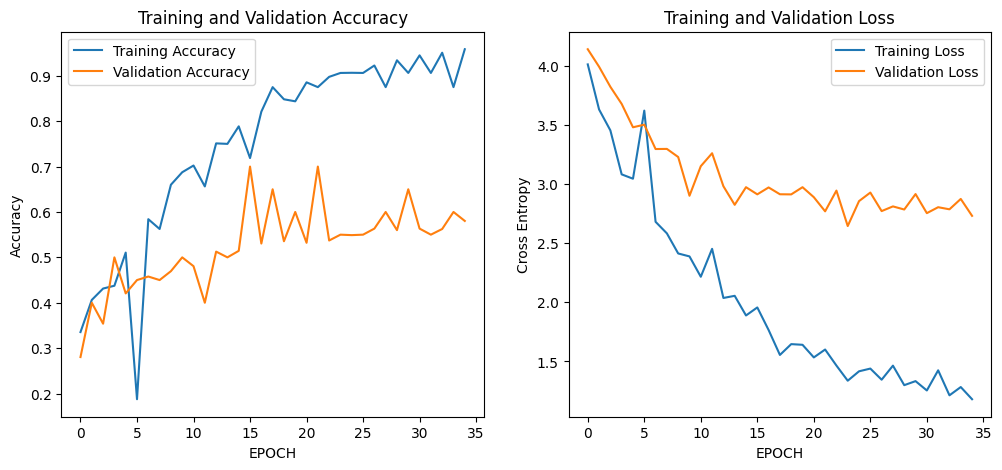

In [ ]:
# Create the figure and subplots in-line
plt.figure(figsize=(12, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('EPOCH')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plot
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

prediction = model.predict(test_dataset) # Make predictions on the test data
predicted_labels = np.argmax(prediction, axis=1) # Convert one-hot encoded predictions to class labels
true_labels = test_dataset.classes # Get the true labels from the test generator
top1_acc = accuracy_score(true_labels, predicted_labels) # Calculate the Top-1 accuracy


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(true_labels, predicted_labels) # Calculate confusion matrix
class_acc = np.diag(cf_matrix) / cf_matrix.sum(axis=1)
avg_acc_per_class = np.mean(class_acc) # Calculate the average accuracy per class

In [ ]:
print("Top-1 Accuracy: {:.2f}%".format(top1_acc * 100))
print("Average Accuracy per Class: {:.2f}%".format(avg_acc_per_class * 100))


Top-1 Accuracy: 58.14%
Average Accuracy per Class: 57.39%
